# Quantum optical reservoir computing powered by boson sampling

This approach builds upon prior work by [Sakurai and al.](https://opg.optica.org/opticaq/abstract.cfm?URI=opticaq-3-3-238).

This notebook demonstrates the **Quantum Optical Reservoir Computing (QORC)** experiment using the _MerLin_ quantum machine learning framework. The code replicates the performance results of quantum feature-based classification on the MNIST dataset, showcasing the proof-of-concept benefits of quantum reservoirs for machine learning tasks.

QORC leverages **boson sampling** to compute highly non-linear quantum features from input data. These features, generated through photonic circuits, capture complex patterns that are difficult to extract classically. A classical linear layer is then trained on these quantum-encoded features, forming a hybrid quantum-classical classifier. This approach demonstrates how quantum reservoirs can outperform classical feature extraction by leveraging the exponential expressivity of photonic circuits, enabling enhanced classification performance on complex datasets.

## 1. Parameters definition

In [5]:
# Main parameters
n_photons = 3
n_modes = 20
seed = 42

# Dataset parameters
fold_index = 0
n_fold = 5

# Training parameters
n_epochs = 100
batch_size = 100
learning_rate = 0.05
reduce_lr_patience = 10
reduce_lr_factor = 0.5
num_workers = 0
pin_memory = False
f_out_weights= "f_weights_out.pth"

# Other parameters
b_no_bunching = True
b_use_tensorboard = False
device_name = "cpu"
outdir = "outdir"


### Parameters explanation

#### Photonic Circuit Parameters

- **n_modes** : Defines the number of modes in the photonic circuit, analogous to the width of a data bus in classical computing. Photons propagate through linear optical components (e.g., phase shifters and beamsplitters).

- **n_photons** :
  Number of photons injected into the circuit. The expressiveness of the quantum layer grows exponentially with this parameter, as it directly determines the dimensionality of the output space—specifically, the number of possible Fock states (photon number distributions across modes).

- **b_no_bunching** :
  Enforces the constraint that at most one photon is detected per mode (output channel). This simplifies computation by excluding photon bunching cases. It is a valid approximation when the number of photons squared (**n_photons^2**) is significantly smaller than the number of modes (n_modes), ensuring that the probability of bunching remains negligible

---

#### Reproducibility
- **seed** :
  Controls the reproducibility of the experiment by fixing random number generators for Python, NumPy, PyTorch, and CUDA. If negative, then RNGs are not seeded.

---

#### Data Splitting
- **fold_index** :
  Indicates which fold of the dataset is used for validation during cross-validation.

- **n_fold** :
  Specifies the number of folds for cross-validation, determining how the dataset is split into training and validation sets.

---

#### Training Parameters
- **n_epochs** :
  Sets the number of training epochs (full passes through the dataset).

- **batch_size** :
  Number of images processed simultaneously in each stochastic gradient descent iteration.

- **learning_rate** :
  Step size for parameter updates. Higher values speed up learning but may reduce stability, while lower values ensure stability but may slow convergence.
  
The training parameters were selected to match those reported in the reference article.

## 2. Librairies loading & logging configuration


In [6]:
import os
import time
import datetime as dt
import math
import random
import logging
from pathlib import Path

import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import perceval as pcvl
import merlin as ML
from merlin.datasets.mnist_digits import get_data_train_original, get_data_test_original

from lib.lib_datasets import (
    tensor_dataset,
    get_dataloader,
    split_fold_numpy,
)
from lib.lib_learning import get_device, model_eval, model_fit
from implementation import configure_logging



##################################
# Activate logging
configure_logging("info")  # basic console logging before config is resolved
logger = logging.getLogger(__name__)

# Prepare output directory with timestamped run folder
timestamp = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
base_out = Path(outdir)
run_dir = base_out / f"run_{timestamp}"
run_dir.mkdir(parents=True, exist_ok=True)

# Configure logging based on resolved config and add file handler in the run directory
configure_logging("info", run_dir / "run.log")


## 3. MNIST Dataset loading from MerLin API

The MerLin API provides convenient functions to load the MNIST dataset:

* get_data_train_original() for the training set,
* get_data_test_original() for the test set.

2025-10-09 16:21:56 | INFO | __main__ | Call to qorc_encoding_and_linear_training: n_photons=3, n_modes=20, run_seed=42, fold_index=0
2025-10-09 16:21:56 | INFO | __main__ | Loading MNIST data...
2025-10-09 16:21:57 | INFO | __main__ | Datasets sizes:
2025-10-09 16:21:57 | INFO | __main__ | (48000,)
2025-10-09 16:21:57 | INFO | __main__ | (48000, 784)
2025-10-09 16:21:57 | INFO | __main__ | (12000,)
2025-10-09 16:21:57 | INFO | __main__ | (12000, 784)
2025-10-09 16:21:57 | INFO | __main__ | (10000,)
2025-10-09 16:21:57 | INFO | __main__ | (10000, 784)


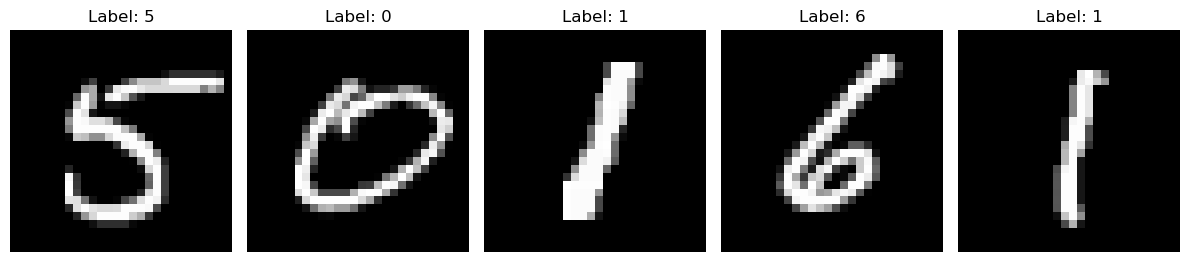

In [7]:
storage_device = torch.device("cpu")
compute_device = get_device(device_name)

run_seed = seed
if run_seed >= 0:
    # Seeding to control the random generators
    random.seed(run_seed)
    np.random.seed(run_seed)
    torch.manual_seed(seed=run_seed)
    torch.cuda.manual_seed_all(seed=run_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.use_deterministic_algorithms(mode=False)

logger.info(
    "Call to qorc_encoding_and_linear_training: n_photons={}, n_modes={}, run_seed={}, fold_index={}".format(
        n_photons, n_modes, run_seed, fold_index
    )
)
time_t1 = time.time()

logger.info("Loading MNIST data...")
val_train_data, val_train_label, _ = get_data_train_original()
val_train_data = (
    val_train_data.reshape(val_train_data.shape[0], -1).astype(np.float32) / 255.0
)

val_label, val_data, train_label, train_data = split_fold_numpy(
    val_train_label, val_train_data, n_fold, fold_index, split_seed=run_seed
)

test_data, test_label, _ = get_data_test_original()
test_data = test_data.reshape(test_data.shape[0], -1).astype(np.float32) / 255.0
n_pixels = 28 * 28  # MNIST images size
n_classes = 10  # 10 classes, one for each figure

logger.info("Datasets sizes:")
logger.info(train_label.shape)  # (48000,)
logger.info(train_data.shape)  # (48000, 784)
logger.info(val_label.shape)  # (12000,)
logger.info(val_data.shape)  # (12000, 784)
logger.info(test_label.shape)  # (10000,)
logger.info(test_data.shape)  # (10000, 784)

# Display the first 5 images from the training set
plt.figure(figsize=(12, 3))  # Width x Height in inches
for i in range(5):
    # Reshape flattened data (784,) into a 28x28 image
    image = train_data[i].reshape(28, 28)
    plt.subplot(1, 5, i + 1)  # 1 row, 5 columns, position i+1
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {train_label[i]}")
    plt.axis('off')  # Hide axes
plt.tight_layout()  # Adjust spacing between images
plt.show()

## 4. Definition of the Quantum Circuit and the Quantum Layer


### Quantum Circuit

In the QORC experiment, the architecture comprises a pre-circuit—an M-mode random Haar-uniform interferometer with N single-photon inputs—that generates a high-dimensional photonic resource state by distributing the photons across the modes. This state is then modulated by a column of phase shifters, which encode the classical input data (e.g., PCA-transformed features) into the quantum circuit by adjusting the optical phases. The processed state is further transformed by a reservoir, implemented as a second M-mode random interferometer (often identical to the pre-circuit), which enhances the non-linearity of the quantum features. The final output, a distribution over Fock states, serves as a highly expressive feature vector for subsequent classical processing, such as linear classification. The combination of the pre-circuit, phase shifters, and reservoir enables the mapping of input data into a complex quantum feature space, where the dimensionality scales combinatorially with the number of photons and modes, offering a potential advantage over classical feature extraction methods.


In [9]:

unitary = pcvl.Matrix.random_unitary(n_modes)  # Haar-uniform unitary sampling
precircuit = pcvl.Unitary(unitary)
reservoir = precircuit.copy()

# Input Phase Shifters
c_var = pcvl.Circuit(n_modes)
for i in range(n_modes):
    px = pcvl.P(f"px{i + 1}")
    port_range = i
    c_var.add(port_range, pcvl.PS(px))

qorc_circuit = precircuit // c_var // reservoir

### Quantum Layer
The input data is encoded into the phase parameters of the intermediate phase shifters, modulating the optical modes of the photonic circuit. The quantum layer's output consists of Fock-state probabilities (ML.OutputMappingStrategy.NONE), measured via coincidence detection at the circuit's output ports. These probabilities form a high-dimensional, non-linear feature vector, which is then used as input for classical classification tasks.

In [10]:
assert n_photons <= n_modes, (
    "Error with photons_input_mode: Too many photons versus modes."
)
step = (n_modes - 1) / (n_photons - 1) if n_photons > 1 else 0
qorc_input_state = [0] * n_modes
for k in range(n_photons):
    index = int(round(k * step))
    qorc_input_state[index] = 1

params_prefix = ["px"]

if b_no_bunching:
    qorc_output_size = math.comb(n_modes, n_photons)
else:
    qorc_output_size = math.comb(n_photons + n_modes - 1, n_photons)

logger.info("MerLin QuantumLayer creation:")
qorc_quantum_layer = ML.QuantumLayer(
    input_size=n_modes,  # Nb input features = nb modes
    output_size=qorc_output_size,  # Nb output classes = nb modes
    circuit=qorc_circuit,  # QORC quantum circuit
    trainable_parameters=[],  # Circuit is not trainable
    input_parameters=params_prefix,  # Input encoding parameters
    input_state=qorc_input_state,  # Initial photon state
    output_mapping_strategy=ML.OutputMappingStrategy.NONE,  # Output: Get all Fock states probas
    # See: https://merlinquantum.ai/user_guide/output_mappings.html
    no_bunching=b_no_bunching,
    device=torch.device(device_name),
)
logger.info(str(qorc_quantum_layer))


2025-10-09 16:22:17 | INFO | __main__ | MerLin QuantumLayer creation:
2025-10-09 16:22:17 | INFO | __main__ | QuantumLayer(custom_circuit, input_size=20, output_size=1140)


## 5. Quantum features computation
First, **PCA (Principal Component Analysis)** is applied to reduce the dimensionality of the input data, matching it to the number of modes in the quantum circuit. The resulting PCA components are then normalized using a **global min-max scaling**, ensuring compatibility with the phase shifters in the MerLin framework, which require bounded input values (to the range [0, 1]). After encoding the normalized data with the quantm layer, the output Fock-state probabilities are further standardized using a **StandardScaler**. This final normalization step improves the convergence and performance of the subsequent **linear classification layer**.

In [11]:
logger.info("Creation of the encoder of the quantum reservoir...")

# 1) PCA Components computation
pca = PCA(n_components=n_modes)
train_data_pca = pca.fit_transform(train_data)
val_data_pca = pca.transform(val_data)
test_data_pca = pca.transform(test_data)

# 2) PCA comp normalization (to [0, 1] (global min/max) )
pca_train_global_min = train_data_pca.min()
pca_train_global_max = train_data_pca.max()

def normalize_global_min_max(data, global_min, global_max):
    epsilon = 1e-8  # Avoid zero division
    return (data - global_min) / (global_max - global_min + epsilon)

train_data_pca_norm = normalize_global_min_max(
    train_data_pca, pca_train_global_min, pca_train_global_max
)
val_data_pca_norm = normalize_global_min_max(
    val_data_pca, pca_train_global_min, pca_train_global_max
)
test_data_pca_norm = normalize_global_min_max(
    test_data_pca, pca_train_global_min, pca_train_global_max
)

logger.info("Quantum features size: {}".format(qorc_output_size))
logger.info("Encoding of the PCA comps to quantum features...")
time_t2 = time.time()
train_data_qorc = qorc_quantum_layer(
    torch.tensor(train_data_pca_norm, dtype=torch.float32, device=compute_device)
)
val_data_qorc = qorc_quantum_layer(
    torch.tensor(val_data_pca_norm, dtype=torch.float32, device=compute_device)
)
test_data_qorc = qorc_quantum_layer(
    torch.tensor(test_data_pca_norm, dtype=torch.float32, device=compute_device)
)
logger.info("Encoding over.")
time_t3 = time.time()

# 4) Quantum features normalization (standard_scaler)
qorc_train_mean = train_data_qorc.detach().mean(dim=0)
qorc_train_std = train_data_qorc.detach().std(dim=0)

def normalize_standard_scaler(data, mean, std):
    epsilon = 1e-8  # Avoid zero division
    return (data - mean) / (std + epsilon)

train_data_qorc_norm = normalize_standard_scaler(
    train_data_qorc, qorc_train_mean, qorc_train_std
)
val_data_qorc_norm = normalize_standard_scaler(
    val_data_qorc, qorc_train_mean, qorc_train_std
)
test_data_qorc_norm = normalize_standard_scaler(
    test_data_qorc, qorc_train_mean, qorc_train_std
)

2025-10-09 16:22:24 | INFO | __main__ | Creation of the encoder of the quantum reservoir...
2025-10-09 16:22:24 | INFO | __main__ | Quantum features size: 1140
2025-10-09 16:22:24 | INFO | __main__ | Encoding of the PCA comps to quantum features...
2025-10-09 16:22:34 | INFO | __main__ | Encoding over.


## 6. Datasets and dataloader preparation for training

The input of the linear layer is the concatenation of the MNIST images and the quantum features.

In [12]:
dtype = torch.float32
all_train_data = torch.cat(
    (
        torch.tensor(train_data, dtype=dtype, device=compute_device),
        train_data_qorc_norm,
    ),
    dim=1,
)
all_val_data = torch.cat(
    (
        torch.tensor(val_data, dtype=dtype, device=compute_device),
        val_data_qorc_norm,
    ),
    dim=1,
)
all_test_data = torch.cat(
    (
        torch.tensor(test_data, dtype=dtype, device=compute_device),
        test_data_qorc_norm,
    ),
    dim=1,
)

# Datasets
ds_train = tensor_dataset(
    all_train_data,
    train_label,
    storage_device,
    dtype=torch.float32,
    transform=None,
    n_side_pixels=28,
)
ds_val = tensor_dataset(
    all_val_data, val_label, storage_device, dtype=torch.float32
)
ds_test = tensor_dataset(
    all_test_data, test_label, storage_device, dtype=torch.float32
)

logger.info("train dataset len: {}".format(len(ds_train)))
logger.info("val dataset len  : {}".format(len(ds_val)))
logger.info("test dataset len : {}".format(len(ds_test)))

# Dataloaders
shuffle_train = True
shuffle_test = False
train_loader = get_dataloader(
    ds_train, batch_size, shuffle_train, num_workers, pin_memory, run_seed
)
val_loader = get_dataloader(
    ds_val, batch_size, shuffle_test, num_workers, pin_memory, run_seed
)
test_loader = get_dataloader(
    ds_test, batch_size, shuffle_test, num_workers, pin_memory, run_seed
)

logger.info("train loader len: {}".format(len(train_loader)))
logger.info("val loader len  : {}".format(len(val_loader)))
logger.info("test loader len : {}".format(len(test_loader)))



2025-10-09 16:22:39 | INFO | __main__ | train dataset len: 48000
2025-10-09 16:22:39 | INFO | __main__ | val dataset len  : 12000
2025-10-09 16:22:39 | INFO | __main__ | test dataset len : 10000
2025-10-09 16:22:39 | INFO | __main__ | train loader len: 480
2025-10-09 16:22:39 | INFO | __main__ | val loader len  : 120
2025-10-09 16:22:39 | INFO | __main__ | test loader len : 100


## 7. Model Definition: Linear Classifier

The trained model consists of a standard PyTorch linear layer (nn.Linear), used to evaluate the quality of the quantum features by measuring the test accuracy. This simple classifier demonstrates how effectively the quantum reservoir transforms the input data into discriminative features.

In [13]:
logger.info("Prepare the linear classifier")

n_model_input_features = n_pixels + qorc_output_size
logger.info("n_model_input_features: {}".format(n_model_input_features))
linear = nn.Linear(
    n_model_input_features, n_classes, bias=True, device=compute_device
)

nn.init.xavier_uniform_(linear.weight)  # Xavier uniforme init (Glorot)
nn.init.zeros_(linear.bias)
model = linear
model.to(compute_device)
model.train()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

criterion = nn.CrossEntropyLoss(reduction="sum")


2025-10-09 16:22:42 | INFO | __main__ | Prepare the linear classifier
2025-10-09 16:22:42 | INFO | __main__ | n_model_input_features: 1924


## 8. Launching the Training Process

Following the reference article, the AdaGrad optimizer is used for training. The validation set is exclusively used for model selection based on the lowest validation loss. Consequently, no early stopping strategy is applied in this experiment.

In [14]:
logger.info("Evaluation before training (on test set)")
calc_accuracy = True
printPerf = True
_eval_test = model_eval(
    model, test_loader, criterion, compute_device, logger, calc_accuracy, printPerf
)

logger.info("Beginning of training")
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, eps=1e-7)

if b_use_tensorboard:
    from torch.utils.tensorboard import SummaryWriter

    xp_name = (
        str(n_photons)
        + "photons_"
        + str(n_modes)
        + "modes_"
        + str(run_seed)
        + "seed_"
        + str(fold_index)
        + "fold"
    )
    tf_train_writer = SummaryWriter(
        os.path.join(run_dir, "runs/" + xp_name + "_train")
    )
    tf_val_writer = SummaryWriter(os.path.join(run_dir, "runs/" + xp_name + "_val"))
else:
    tf_train_writer = None
    tf_val_writer = None

early_stop_patience = n_epochs
early_stop_min_delta = 0.000001
b_use_cosine_scheduler = False
[
    train_loss_history,
    train_accuracy_history,
    val_loss_history,
    val_accuracy_history,
    duree_totale,
    best_val_epoch,
] = model_fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    n_epochs,
    os.path.join(run_dir, f_out_weights),
    early_stop_patience,
    early_stop_min_delta,
    reduce_lr_patience,
    reduce_lr_factor,
    compute_device,
    logger,
    b_use_cosine_scheduler,
    tf_train_writer=tf_train_writer,
    tf_val_writer=tf_val_writer,
    calc_accuracy=calc_accuracy,
)

logger.info("Training over.")
n_train_epochs = len(train_loss_history)
time_t4 = time.time()


2025-10-09 16:22:48 | INFO | __main__ | Evaluation before training (on test set)
2025-10-09 16:22:49 | INFO | __main__ | 100/100 - 0s - loss: 2.6531 - accuracy: 0.1244
2025-10-09 16:22:49 | INFO | __main__ | Beginning of training
2025-10-09 16:22:52 | INFO | __main__ | Call model_fit(), with 19250 parameters to train.
2025-10-09 16:22:52 | INFO | __main__ | tag heure: 2025-10-09_16:22:52 (1760019772.2914648)
2025-10-09 16:22:54 | INFO | __main__ | Epoch 1/100
2025-10-09 16:22:54 | INFO | __main__ | 480/480 - 2s - loss: 0.3333 - accuracy: 0.9249 - val_loss: 0.1638 - val_accuracy: 0.9516
2025-10-09 16:22:55 | INFO | __main__ | Epoch 00001: val_loss improved from inf to 0.16382, saving model to outdir\run_20251009-162155\f_weights_out.pth
2025-10-09 16:22:55 | INFO | __main__ | tag heure: 2025-10-09_16:22:55 (1760019775.0015202)
2025-10-09 16:22:57 | INFO | __main__ | Epoch 2/100
2025-10-09 16:22:57 | INFO | __main__ | 480/480 - 2s - loss: 0.1382 - accuracy: 0.9589 - val_loss: 0.1486 - va

## 9. Results

After training, the best model (selected based on the lowest validation loss) is loaded, and its accuracy is evaluated on the training, validation, and test datasets.

In [15]:
logger.info("Final evaluation (on test set)")
best_state_dict = torch.load(
    os.path.join(run_dir, f_out_weights), map_location=compute_device
)

try:
    model.load_state_dict(best_state_dict)
    logger.info("n_model_input_features: {n_model_input_features}")
    [_, train_acc, _] = model_eval(
        model,
        train_loader,
        criterion,
        compute_device,
        logger,
        calc_accuracy,
        printPerf,
    )
    train_acc = int(1000000.0 * train_acc.item()) / 1000000.0
    [_, val_acc, _] = model_eval(
        model,
        val_loader,
        criterion,
        compute_device,
        logger,
        calc_accuracy,
        printPerf,
    )
    val_acc = int(1000000.0 * val_acc.item()) / 1000000.0
    [_, test_acc, _] = model_eval(
        model,
        test_loader,
        criterion,
        compute_device,
        logger,
        calc_accuracy,
        printPerf,
    )
    test_acc = int(1000000.0 * test_acc.item()) / 1000000.0
except RuntimeError as e:
    logger.info(f"Error while loading state_dict : {e}")
    train_acc = float("nan")
    val_acc = float("nan")
    test_acc = float("nan")
time_t5 = time.time()

duration_creation_couche_quantique = int(100.0 * (time_t2 - time_t1)) / 100.0
logger.info(
    "Duration - Quantum layer creation: {}s".format(
        duration_creation_couche_quantique
    )
)
duration_calcul_quantum_features = int(100.0 * (time_t3 - time_t2)) / 100.0
logger.info(
    "Duration - Quantum features encoding: {}s".format(
        duration_calcul_quantum_features
    )
)
duration_qfeatures = (
    duration_creation_couche_quantique + duration_calcul_quantum_features
)
duration_train = int(100.0 * (time_t4 - time_t3)) / 100.0
logger.info("Duration - training: {}s".format(duration_train))
duration_totale = int(100.0 * (time_t5 - time_t1)) / 100.0
logger.info("Duration - total: {}s".format(duration_totale))
logger.info("Best val epoch: {}".format(best_val_epoch))

# Afficher les accuracies après apprentissage
logger.info("Accuracies - train: {:.4f}, val: {:.4f}, test: {:.4f}".format(
    train_acc,
    val_acc,
    test_acc
))


2025-10-09 16:26:35 | INFO | __main__ | Final evaluation (on test set)
2025-10-09 16:26:35 | INFO | __main__ | n_model_input_features: {n_model_input_features}
2025-10-09 16:26:36 | INFO | __main__ | 480/480 - 0s - loss: 0.0358 - accuracy: 0.9911
2025-10-09 16:26:36 | INFO | __main__ | 120/120 - 0s - loss: 0.0938 - accuracy: 0.9710
2025-10-09 16:26:36 | INFO | __main__ | 100/100 - 0s - loss: 0.0987 - accuracy: 0.9722
2025-10-09 16:26:36 | INFO | __main__ | Duration - Quantum layer creation: 27.87s
2025-10-09 16:26:36 | INFO | __main__ | Duration - Quantum features encoding: 9.86s
2025-10-09 16:26:36 | INFO | __main__ | Duration - training: 221.73s
2025-10-09 16:26:36 | INFO | __main__ | Duration - total: 279.68s
2025-10-09 16:26:36 | INFO | __main__ | Best val epoch: 68
2025-10-09 16:26:36 | INFO | __main__ | Accuracies - train: 0.9911, val: 0.9710, test: 0.9722


## Conclusion

This notebook successfully **reproduces and occasionally surpasses** the reference results (**98.96% train accuracy, 97.05% test accuracy** with 3 photons and 20 modes), serving as a **proof of concept** for the advantages of **quantum feature extraction** in machine learning.

### Key Findings
- **Performance Validation**: The hybrid QORC model (quantum reservoir + linear classifier) matches the original benchmarks, confirming the **effectiveness of quantum features** for MNIST classification.
- **Quantum Advantage**: The photonic circuit's ability to generate **highly non-linear features**—intractable for classical methods—demonstrates the potential of quantum-enhanced approaches.
- **Scalability**: While this experiment uses a modest configuration (3 photons, 20 modes), the exponential scaling of the Fock space suggests even greater benefits for larger systems.1. **NISQ Compatibility**:
   The QORC architecture is inherently **robust to noise**, as it relies on **repeatable quantum feature patterns** rather than precise quantum state fidelity. This makes it a promising candidate for deployment on **current-generation NISQ (Noisy Intermediate-Scale Quantum) devices**, where systematic errors can be mitigated through statistical repetition.
- **NISQ Compatibility**:
   The QORC architecture is inherently **robust to noise**, as it relies on **repeatable quantum feature patterns** rather than precise quantum state fidelity. This makes it a promising candidate for deployment on **current-generation NISQ (Noisy Intermediate-Scale Quantum) devices**, where systematic errors can be mitigated through statistical repetition.




## Environment Setup
The notebook was tested with the following library versions:

In [ ]:
import sys
import sklearn
import matplotlib

print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Perceval: {pcvl.__version__}")
print(f"MerLin: {ML.__version__}")


```
Python: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:29:09) [MSC v.1943 64 bit (AMD64)]
NumPy: 2.3.2
Scikit-learn: 1.7.1
Matplotlib: 3.10.5
PyTorch: 2.7.1
Perceval: 0.13.2
MerLin: 0.1.0
```